In [ ]:
!wget -q --show-progress https://github.com/RecoHut-Datasets/movielens_1m/raw/v3/ml1m.csv
!unzip ml1m.zip

ml1m.csv            100%[===================>]  13.75M  --.-KB/s    in 0.1s    
unzip:  cannot find or open ml1m.zip, ml1m.zip.zip or ml1m.zip.ZIP.


In [ ]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.models import Model, Sequential
from keras.layers import Embedding, Flatten, Input, Dropout, Dense, Concatenate, Dot, Lambda
from keras.optimizers import Adam
from keras import backend as K

from sklearn.metrics import precision_score, recall_score, ndcg_score, mean_absolute_error, mean_squared_error, r2_score

In [ ]:
dataset = 'ml1m'
latent_dim = 5
like_threshold = 4
steps_per_epoch = None

deepmf_epochs = 10
ncf_epochs = 10
neumf_epochs = 10
vdeepmf_epochs = 6
vncf_epochs = 9
vneumf_epochs = 5

In [ ]:
df = pd.read_csv('/content/ml1m.csv', delimiter = ',')

num_users = df.user.max() + 1
num_items = df.item.max() + 1

X = df[['user', 'item']].to_numpy()
y = df[['rating']].to_numpy()


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

X_train = [X_train[:,0], X_train[:,1]]
X_test = [X_test[:,0], X_test[:,1]]

In [ ]:
X_train

[array([3020, 4656,   20, ..., 1084, 4604, 1013]),
 array([1064, 1349, 2402, ..., 2011,  196, 1149])]

DEEPMF


In [ ]:
user_input = Input(shape=[1])
user_embedding = Embedding(num_users, latent_dim)(user_input)
user_vec = Flatten()(user_embedding)

item_input = Input(shape=[1])
item_embedding = Embedding(num_items, latent_dim)(item_input)
item_vec = Flatten()(item_embedding)

dot = Dot(axes=1)([item_vec, user_vec])

DeepMF = Model([user_input, item_input], dot)

In [ ]:
with tf.device('/GPU:1'):
    DeepMF.compile(optimizer='adam', metrics=['mae'], loss='mean_squared_error')
    DeepMF.summary()

    deepmf_report = DeepMF.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=deepmf_epochs, steps_per_epoch=steps_per_epoch, verbose=1)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 1, 5)           │         18,530 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 1, 5)           │         30,200 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 5)              │              0 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 5)              │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dot (Dot)                 │ (None, 1)              │              0 │ flatten_1[0][0],       │
│                           │                        │                │ flatten[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 48,730 (190.35 KB)

 Trainable params: 48,730 (190.35 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 49s 2ms/step - loss: 8.3729 - mae: 2.4727 - val_loss: 1.0403 - val_mae: 0.7944
Epoch 2/10
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 78s 2ms/step - loss: 0.9546 - mae: 0.7653 - val_loss: 0.8869 - val_mae: 0.7415
Epoch 3/10
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 46s 2ms/step - loss: 0.8722 - mae: 0.7355 - val_loss: 0.8733 - val_mae: 0.7366
Epoch 4/10
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step - loss: 0.8589 - mae: 0.7304 - val_loss: 0.8620 - val_mae: 0.7308
Epoch 5/10
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step - loss: 0.8459 - mae: 0.7244 - val_loss: 0.8459 - val_mae: 0.7245
Epoch 6/10
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step - loss: 0.8272 - mae: 0.7160 - val_loss: 0.8286 - val_mae: 0.7165
Epoch 7/10
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 47s 2ms/step - loss: 0.8050 - mae: 0.7057 - val_loss: 0.8158 - val_mae: 0.7104
Epoch 8/10
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 80s 2ms/step - loss: 0.7887 - mae: 0.6972 - val_loss: 0.8062 - val_mae: 0.7053
Epoch 9/10
25006

NCF


In [ ]:
item_input = Input(shape=[1], name='item-input')
item_embedding = Embedding(num_items, latent_dim, name='item-embedding')(item_input)
item_vec = Flatten(name='item-flatten')(item_embedding)

user_input = Input(shape=[1], name='user-input')
user_embedding = Embedding(num_users, latent_dim, name='user-embedding')(user_input)
user_vec = Flatten(name='user-flatten')(user_embedding)

concat = Concatenate(axis=1, name='item-user-concat')([item_vec, user_vec])
fc_1 = Dense(70, name='fc-1', activation='relu')(concat)
fc_1_dropout = Dropout(0.5, name='fc-1-dropout')(fc_1)
fc_2 = Dense(30, name='fc-2', activation='relu')(fc_1_dropout)
fc_2_dropout = Dropout(0.4, name='fc-2-dropout')(fc_2)
fc_3 = Dense(1, name='fc-3', activation='relu')(fc_2_dropout)

NCF = Model([user_input, item_input], fc_3)

In [ ]:
with tf.device('/GPU:1'):
    NCF.compile(optimizer='adam', metrics=['mae'], loss='mean_squared_error')
    NCF.summary()

    ncf_report = NCF.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=ncf_epochs, steps_per_epoch=steps_per_epoch, verbose=1)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ item-input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user-input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ item-embedding            │ (None, 1, 5)           │         18,530 │ item-input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user-embedding            │ (None, 1, 5)           │         30,200 │ user-input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ item-flatten (Flatten)    │ (None, 5)              │              0 │ item-embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user-flatten (Flatten)    │ (None, 5)              │              0 │ user-embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ item-user-concat          │ (None, 10)             │              0 │ item-flatten[0][0],    │
│ (Concatenate)             │                        │                │ user-flatten[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fc-1 (Dense)              │ (None, 70)             │            770 │ item-user-concat[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fc-1-dropout (Dropout)    │ (None, 70)             │              0 │ fc-1[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fc-2 (Dense)              │ (None, 30)             │          2,130 │ fc-1-dropout[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fc-2-dropout (Dropout)    │ (None, 30)             │              0 │ fc-2[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fc-3 (Dense)              │ (None, 1)              │             31 │ fc-2-dropout[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 51,661 (201.80 KB)

 Trainable params: 51,661 (201.80 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 59s 2ms/step - loss: 1.3881 - mae: 0.9179 - val_loss: 0.8510 - val_mae: 0.7327
Epoch 2/10
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 57s 2ms/step - loss: 0.8468 - mae: 0.7285 - val_loss: 0.8364 - val_mae: 0.7184
Epoch 3/10
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 78s 2ms/step - loss: 0.8305 - mae: 0.7199 - val_loss: 0.8119 - val_mae: 0.7081
Epoch 4/10
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 55s 2ms/step - loss: 0.8168 - mae: 0.7125 - val_loss: 0.8050 - val_mae: 0.7061
Epoch 5/10
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 82s 2ms/step - loss: 0.8040 - mae: 0.7060 - val_loss: 0.7911 - val_mae: 0.6991
Epoch 6/10
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 53s 2ms/step - loss: 0.7939 - mae: 0.7004 - val_loss: 0.7893 - val_mae: 0.6962
Epoch 7/10
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 55s 2ms/step - loss: 0.7882 - mae: 0.6982 - val_loss: 0.7870 - val_mae: 0.6989
Epoch 8/10
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 53s 2ms/step - loss: 0.7836 - mae: 0.6953 - val_loss: 0.7881 - val_mae: 0.6956
Epoch 9/10
25006

VDEEPMF


In [ ]:
batch_size = 32
latent_dim = 13  # Increased latent dimension for more capacity

import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, Lambda, Flatten, Dot, Add
from tensorflow.keras.models import Model

def sampling(args):
    z_mean, z_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean), mean=0.0, stddev=1.0)
    return z_mean + tf.exp(0.5 * z_var) * epsilon  # No clamping for overfitting

# User Input
user_input = Input(shape=[1])
user_embedding = Embedding(
    num_users, latent_dim,
    embeddings_initializer='he_uniform'  # Advanced initializer for faster convergence
)(user_input)
user_embedding_mean = Dense(latent_dim)(user_embedding)
user_embedding_var = Dense(latent_dim)(user_embedding)
user_embedding_z = Lambda(sampling, output_shape=(latent_dim,))([user_embedding_mean, user_embedding_var])
user_vec = Flatten()(user_embedding_z)
user_bias = Embedding(num_users, 1)(user_input)  # User bias

# Item Input
item_input = Input(shape=[1])
item_embedding = Embedding(
    num_items, latent_dim,
    embeddings_initializer='he_uniform'
)(item_input)
item_embedding_mean = Dense(latent_dim)(item_embedding)
item_embedding_var = Dense(latent_dim)(item_embedding)
item_embedding_z = Lambda(sampling, output_shape=(latent_dim,))([item_embedding_mean, item_embedding_var])
item_vec = Flatten()(item_embedding_z)
item_bias = Embedding(num_items, 1)(item_input)  # Item bias

# Dot Product with Bias
dot = Dot(axes=1)([item_vec, user_vec])
output = Add()([dot, Flatten()(user_bias), Flatten()(item_bias)])  # Add biases

# Model
VDeepMF = Model([user_input, item_input], output)

In [ ]:
with tf.device('/GPU:1'):
    VDeepMF.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),  # Use fixed LR for overfitting
        metrics=['mae'],
        loss='mean_squared_error'
    )
    VDeepMF.summary()

    vdeepmf_report = VDeepMF.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=6,
        batch_size=batch_size,
        steps_per_epoch=steps_per_epoch,
        verbose=1
    )

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_4 (Embedding)   │ (None, 1, 13)          │         48,178 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 1, 13)          │         78,520 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1, 13)          │            182 │ embedding_4[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1, 13)          │            182 │ embedding_4[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1, 13)          │            182 │ embedding_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1, 13)          │            182 │ embedding_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 13)             │              0 │ dense_2[0][0],         │
│                           │                        │                │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 13)             │              0 │ dense[0][0],           │
│                           │                        │                │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 13)             │              0 │ lambda_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 13)             │              0 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 1, 1)           │          6,040 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_5 (Embedding)   │ (None, 1, 1)           │          3,706 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dot_1 (Dot)               │ (None, 1)              │              0 │ flatten_3[0][0],       │
│                           │                        │                │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_4 (Flatten)       │ (None, 1)              │              0 │ embedding_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_5 (Flatten)       │ (None, 1)              │              0 │ embedding_5[0][0]      │
├──────────────────────

 Total params: 137,172 (535.83 KB)

 Trainable params: 137,172 (535.83 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/6
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 65s 2ms/step - loss: 5.4221 - mae: 1.5473 - val_loss: 0.8267 - val_mae: 0.7214
Epoch 2/6
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 79s 2ms/step - loss: 0.7932 - mae: 0.7017 - val_loss: 0.7743 - val_mae: 0.6942
Epoch 3/6
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 82s 2ms/step - loss: 0.7378 - mae: 0.6738 - val_loss: 0.7596 - val_mae: 0.6825
Epoch 4/6
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 83s 2ms/step - loss: 0.7043 - mae: 0.6565 - val_loss: 0.7545 - val_mae: 0.6827
Epoch 5/6
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 60s 2ms/step - loss: 0.6838 - mae: 0.6456 - val_loss: 0.7481 - val_mae: 0.6783
Epoch 6/6
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 59s 2ms/step - loss: 0.6611 - mae: 0.6338 - val_loss: 0.7470 - val_mae: 0.6765


VNCF

In [ ]:
batch_size = 32
latent_dim = 13  # Updated latent dimension for consistency

import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Embedding, Dense, Lambda, Flatten, Dropout, Concatenate, Add
)
from tensorflow.keras.models import Model

# Sampling function for latent space
def sampling(args):
    z_mean, z_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean), mean=0.0, stddev=1.0)
    return z_mean + tf.exp(0.5 * z_var) * epsilon

# User Input
user_input = Input(shape=[1])
user_embedding = Embedding(
    num_users, latent_dim,
    embeddings_initializer='he_uniform'  # Updated initializer
)(user_input)
user_embedding_mean = Dense(latent_dim, activation='linear')(user_embedding)
user_embedding_var = Dense(latent_dim, activation='linear')(user_embedding)
user_embedding_z = Lambda(sampling)([user_embedding_mean, user_embedding_var])
user_vec = Flatten()(user_embedding_z)
user_bias = Embedding(num_users, 1)(user_input)  # User bias
user_bias_flat = Flatten()(user_bias)

# Item Input
item_input = Input(shape=[1])
item_embedding = Embedding(
    num_items, latent_dim,
    embeddings_initializer='he_uniform'  # Updated initializer
)(item_input)
item_embedding_mean = Dense(latent_dim, activation='linear')(item_embedding)
item_embedding_var = Dense(latent_dim, activation='linear')(item_embedding)
item_embedding_z = Lambda(sampling)([item_embedding_mean, item_embedding_var])
item_vec = Flatten()(item_embedding_z)
item_bias = Embedding(num_items, 1)(item_input)  # Item bias
item_bias_flat = Flatten()(item_bias)

# Concatenation Layer
concat = Concatenate(axis=1)([user_vec, item_vec])

# Fully Connected Layers
fc_1 = Dense(80, activation='relu', name='fc-1')(concat)
fc_1_dropout = Dropout(0.6, name='fc-1-dropout')(fc_1)
fc_2 = Dense(25, activation='relu', name='fc-2')(fc_1_dropout)
fc_2_dropout = Dropout(0.4, name='fc-2-dropout')(fc_2)

# Adding Biases to the Final Output
output_with_biases = Add(name='output')([Dense(1, activation='relu', name='fc-3')(fc_2_dropout), user_bias_flat, item_bias_flat])

# Model
VNCF = Model([user_input, item_input], output_with_biases)

# Optional: Summary for verification
VNCF.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_5             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_6 (Embedding)   │ (None, 1, 13)          │         78,520 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_8 (Embedding)   │ (None, 1, 13)          │         48,178 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 1, 13)          │            182 │ embedding_6[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 1, 13)          │            182 │ embedding_6[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 1, 13)          │            182 │ embedding_8[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 1, 13)          │            182 │ embedding_8[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_2 (Lambda)         │ (None, 1, 13)          │              0 │ dense_4[0][0],         │
│                           │                        │                │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_3 (Lambda)         │ (None, 1, 13)          │              0 │ dense_6[0][0],         │
│                           │                        │                │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_6 (Flatten)       │ (None, 13)             │              0 │ lambda_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_8 (Flatten)       │ (None, 13)             │              0 │ lambda_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 26)             │              0 │ flatten_6[0][0],       │
│                           │                        │                │ flatten_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fc-1 (Dense)              │ (None, 80)             │          2,160 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fc-1-dropout (Dropout)    │ (None, 80)             │              0 │ fc-1[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fc-2 (Dense)              │ (None, 25)             │          2,025 │ fc-1-dropout[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fc-2-dropout (Dropout)    │ (None, 25)             │              0 │ fc-2[0][0]             │
├──────────────────────

 Total params: 141,383 (552.28 KB)

 Trainable params: 141,383 (552.28 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
with tf.device('/GPU:1'):
    VNCF.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='mean_squared_error',
        metrics=['mae']
    )
    VNCF.summary()

    vncf_report = VNCF.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs= vncf_epochs,  # Consistent epochs for comparison
        batch_size=batch_size,
        steps_per_epoch=steps_per_epoch,
        verbose=1
    )

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_5             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_6 (Embedding)   │ (None, 1, 13)          │         78,520 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_8 (Embedding)   │ (None, 1, 13)          │         48,178 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 1, 13)          │            182 │ embedding_6[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 1, 13)          │            182 │ embedding_6[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 1, 13)          │            182 │ embedding_8[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 1, 13)          │            182 │ embedding_8[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_2 (Lambda)         │ (None, 1, 13)          │              0 │ dense_4[0][0],         │
│                           │                        │                │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_3 (Lambda)         │ (None, 1, 13)          │              0 │ dense_6[0][0],         │
│                           │                        │                │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_6 (Flatten)       │ (None, 13)             │              0 │ lambda_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_8 (Flatten)       │ (None, 13)             │              0 │ lambda_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 26)             │              0 │ flatten_6[0][0],       │
│                           │                        │                │ flatten_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fc-1 (Dense)              │ (None, 80)             │          2,160 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fc-1-dropout (Dropout)    │ (None, 80)             │              0 │ fc-1[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fc-2 (Dense)              │ (None, 25)             │          2,025 │ fc-1-dropout[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fc-2-dropout (Dropout)    │ (None, 25)             │              0 │ fc-2[0][0]             │
├──────────────────────

 Total params: 141,383 (552.28 KB)

 Trainable params: 141,383 (552.28 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/9
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 76s 3ms/step - loss: 1.5112 - mae: 0.9563 - val_loss: 0.8339 - val_mae: 0.7203
Epoch 2/9
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 76s 3ms/step - loss: 0.8239 - mae: 0.7175 - val_loss: 0.8088 - val_mae: 0.7094
Epoch 3/9
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 81s 3ms/step - loss: 0.7960 - mae: 0.7029 - val_loss: 0.8018 - val_mae: 0.7073
Epoch 4/9
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 66s 3ms/step - loss: 0.7808 - mae: 0.6950 - val_loss: 0.7984 - val_mae: 0.7024
Epoch 5/9
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 68s 3ms/step - loss: 0.7749 - mae: 0.6923 - val_loss: 0.7934 - val_mae: 0.7018
Epoch 6/9
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 81s 3ms/step - loss: 0.7735 - mae: 0.6909 - val_loss: 0.7966 - val_mae: 0.7031
Epoch 7/9
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 67s 3ms/step - loss: 0.7693 - mae: 0.6889 - val_loss: 0.7880 - val_mae: 0.6982
Epoch 8/9
25006/25006 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step - loss: 0.7680 - mae: 0.6877 - val_loss: 0.7878 - val_mae: 0.6980
Epoch 9/9
25006/25006 ━━

METRICS


In [ ]:
methods = ['vdeepmf', 'deepmf', 'vncf', 'ncf']

In [ ]:
preds = pd.DataFrame()

preds['user'] = X_test[0]
preds['item'] = X_test[1]

preds['y_test'] = y_test

In [ ]:
y_true = preds['y_test'].to_numpy()

In [ ]:
preds['deepmf'] = DeepMF.predict(X_test)

6252/6252 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


In [ ]:
preds['ncf'] = NCF.predict(X_test)

6252/6252 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


In [ ]:
n_repeats = 10

In [ ]:
predictions = None

for i in range(n_repeats):
    if i == 0:
        predictions = VDeepMF.predict(X_test)
    else:
        predictions = np.append(predictions, VDeepMF.predict(X_test), axis=1)

preds['vdeepmf'] = np.mean(predictions, axis=1)

6252/6252 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


In [ ]:
predictions = None

for i in range(n_repeats):
    if i == 0:
        predictions = VNCF.predict(X_test)
    else:
        predictions = np.append(predictions, VNCF.predict(X_test), axis=1)

preds['vncf'] = np.mean(predictions, axis=1)

6252/6252 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step


Quality of predictions

In [ ]:
print('MAE:')
for m in methods:
    print('-', m, ':', mean_absolute_error(preds['y_test'], preds[m]))

print('MSD:')
for m in methods:
    print('-', m, ':', mean_squared_error(preds['y_test'], preds[m]))

print('R2:')
for m in methods:
    print('-', m, ':', r2_score(preds['y_test'], preds[m]))

MAE:
- vdeepmf : 0.6763904476269484
- deepmf : 0.6983052739059062
- vncf : 0.6990631864643428
- ncf : 0.6946560171211101
MSD:
- vdeepmf : 0.746641670715014
- deepmf : 0.7931747961408845
- vncf : 0.7907531617347722
- ncf : 0.7829263355067861
R2:
- vdeepmf : 0.40303611086425684
- deepmf : 0.3658313892187758
- vncf : 0.3677675633567037
- ncf : 0.3740253611838379


Quality of recommendations

In [ ]:
recommendations = {}

for m in methods:
    recommendations[m] = {}

X = preds[['user', 'item']].to_numpy()
for user_id in np.unique(X[:,0]):
    indices = np.where(X[:,0] == user_id)[0]

    for m in methods:
        user_pred = np.array([preds[m].to_numpy()[i] for i in indices])
        user_rec = [indices[pos] for pos in np.argsort(user_pred)[::-1]]
        recommendations[m][user_id] = user_rec

In [ ]:
num_recommendations = [2,3,4,5,6,7,8,9,10]

#### Precision, recall and F1

In [ ]:
def recommender_precision_recall(recommendations, y_true, y_pred, N, threshold):
    precision = 0
    recall = 0
    count = 0

    for user_id, indices in recommendations.items():

        valid_user = False
        rec_true = np.zeros(len(indices))
        rec_pred = np.zeros(len(indices))

        for i, index in enumerate(indices):

            if y_true[index] >= threshold:
                rec_true[i] = 1
                valid_user = True

            if i < N and y_pred[index] >= threshold:
                rec_pred[i] = 1

        if valid_user:
            precision += precision_score(rec_true, rec_pred, zero_division=0)
            recall += recall_score(rec_true, rec_pred)
            count += 1

    return precision/count, recall/count

In [ ]:
precision = {}
recall = {}
f1 = {}

for m in methods:
    print(m)

    precision[m] = np.zeros(len(num_recommendations))
    recall[m] = np.zeros(len(num_recommendations))

    for i, n in enumerate(num_recommendations):
        y_pred = preds[m].to_numpy()
        precision[m][i], recall[m][i] = recommender_precision_recall(recommendations[m], y_true, y_pred, n, like_threshold)

    f1[m] = 2 * precision[m] * recall[m] / (precision[m] + recall[m])

vdeepmf
deepmf
vncf
ncf


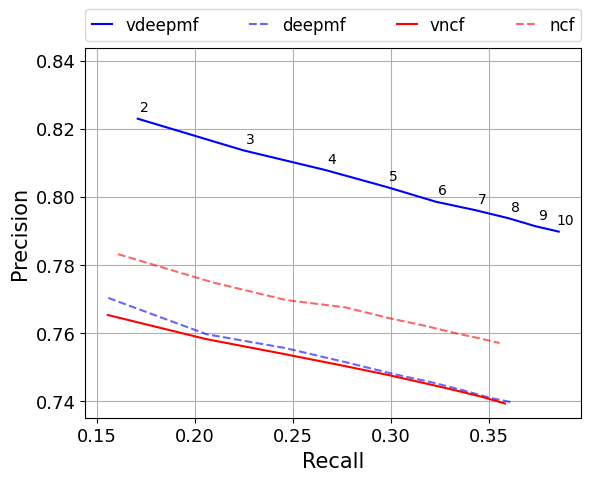

In [ ]:
for m in methods:
    c = 'blue' if 'deepmf' in m else 'red'
    alpha = 1 if m[0] == 'v' else 0.6
    ls = '-' if m[0] == 'v' else '--'

    plt.plot(recall[m], precision[m], c=c, ls=ls, alpha=alpha, label=m)

    if m == 'vdeepmf':
        for i,(r,p) in enumerate(zip(recall[m], precision[m])):
            plt.annotate(num_recommendations[i], (r,p), textcoords="offset points", xytext=(5,5), ha='center')

plt.xlabel('Recall', fontsize=15);
plt.ylabel('Precision', fontsize=15)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.legend(bbox_to_anchor=(0,1.02,1,0.2), fontsize=12, loc="lower left", mode="expand", borderaxespad=0, ncol=len(methods), handlelength=1.2)

plt.grid(True)

ylim_min, ylim_max = plt.ylim()
plt.ylim((ylim_min, ylim_max * 1.02))

plt.savefig('precision-recall.png', dpi=300)

plt.show()

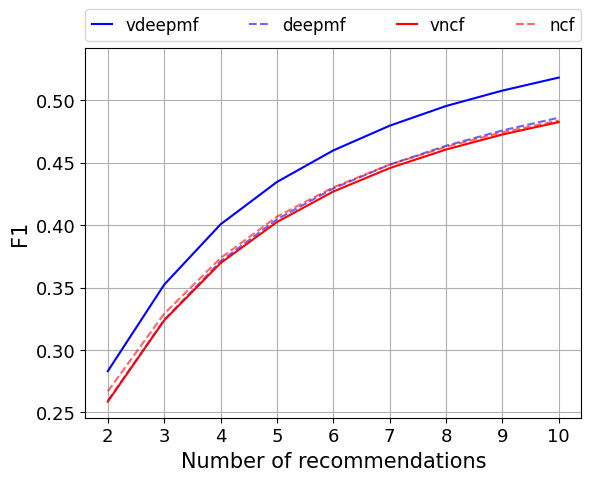

In [ ]:
for m in methods:
    c = 'blue' if 'deepmf' in m else 'red'
    alpha = 1 if m[0] == 'v' else 0.6
    ls = '-' if m[0] == 'v' else '--'

    plt.plot(num_recommendations, f1[m], c=c, ls=ls, alpha=alpha, label=m)

plt.xlabel('Number of recommendations', fontsize=15);
plt.ylabel('F1', fontsize=15)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.legend(bbox_to_anchor=(0,1.02,1,0.2), fontsize=12, loc="lower left", mode="expand", borderaxespad=0, ncol=len(methods), handlelength=1.2)

plt.grid(True)

ylim_min, ylim_max = plt.ylim()
plt.ylim((ylim_min, ylim_max * 1.02))

plt.savefig('f1.png', dpi=300)

plt.show()

#### Novelty

In [ ]:
def recommender_novelty(recommendations, y_true, y_pred, num_recommendations):
    novelty = np.zeros(len(num_recommendations))
    count = np.zeros(len(num_recommendations))

    bincount = np.bincount(X_test[1])

    for user_id, indices in recommendations.items():
        for i, n in enumerate(num_recommendations):
            for index in indices[:n]:
                item_id = X_test[1][index]
                num_item_ratings = bincount[item_id]
                total_num_ratings = len(X_test[1])
                pi = num_item_ratings / total_num_ratings
                novelty[i] += -math.log(pi,2)
                count[i] += 1

    return novelty/count

vdeepmf
deepmf
vncf
ncf


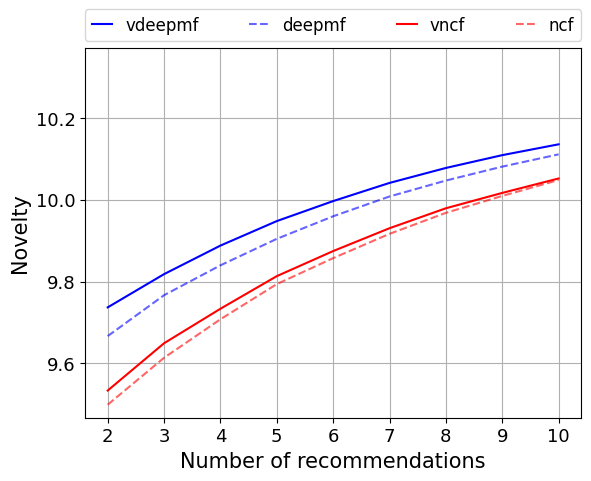

In [ ]:
for m in methods:
    print(m)

    y_pred = preds[m].to_numpy()
    novelty = recommender_novelty(recommendations[m], y_true, y_pred, num_recommendations)

    c = 'blue' if 'deepmf' in m else 'red'
    alpha = 1 if m[0] == 'v' else 0.6
    ls = '-' if m[0] == 'v' else '--'

    plt.plot(num_recommendations, novelty, c=c, ls=ls, alpha=alpha, label=m)

plt.xlabel('Number of recommendations', fontsize=15);
plt.ylabel('Novelty', fontsize=15)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.legend(bbox_to_anchor=(0,1.02,1,0.2), fontsize=12, loc="lower left", mode="expand", borderaxespad=0, ncol=len(methods), handlelength=1.2)

plt.grid(True)

ylim_min, ylim_max = plt.ylim()
plt.ylim((ylim_min, ylim_max * 1.02))

plt.savefig('novelty.png', dpi=300)

plt.show()

#### NDCG

In [ ]:
def recommender_ndcg(recommendations, y_true, y_pred, N):
    ndcg = 0
    count = 0

    for indices in recommendations.values():
        if len(indices) > 1:
            user_true = np.array([y_true[i] for i in indices])
            user_pred = np.array([y_pred[i] for i in indices])

            user_true = np.expand_dims(user_true, axis=0)
            user_pred = np.expand_dims(user_pred, axis=0)

            ndcg += ndcg_score(user_true, user_pred, k=N, ignore_ties=False)
            count += 1

    return ndcg / count

vdeepmf
deepmf
vncf
ncf


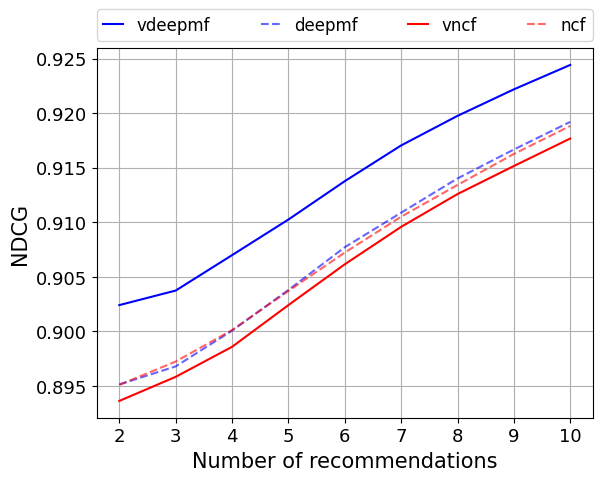

In [ ]:
for m in methods:
    print(m)

    ndcg = np.zeros(len(num_recommendations))

    for i, n in enumerate(num_recommendations):
        y_pred = preds[m].to_numpy()
        ndcg[i] = recommender_ndcg(recommendations[m], y_true, y_pred, n)

    c = 'blue' if 'deepmf' in m else 'red'
    alpha = 1 if m[0] == 'v' else 0.6
    ls = '-' if m[0] == 'v' else '--'

    plt.plot(num_recommendations, ndcg, c=c, ls=ls, alpha=alpha, label=m)

plt.xlabel('Number of recommendations', fontsize=15);
plt.ylabel('NDCG', fontsize=15)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.legend(bbox_to_anchor=(0,1.02,1,0.2), fontsize=12, loc="lower left", mode="expand", borderaxespad=0, ncol=len(methods), handlelength=1.2)

plt.grid(True)

plt.savefig('ndcg.png', dpi=300)

plt.show()